# Test orbits in the Nbody example with a custom force

This example shows you how to contruct your own force routine in Python.  The example is a reimplementation in Python of the method supplied by pyEXP.basis by default.

Begin with the usual imports

In [1]:
import os
import copy
import yaml
import time
import pyEXP
import bisect
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from os.path import exists

plt.rcParams['figure.figsize'] = [12, 9]

### Switch to the working directory
I like to be explicit about my working directory but you don't need to do this here.  It would be sufficient to simply pass the full path to the coefficient factory below.   Change the following line to point at the directory where you've computed the Better example.

In [2]:
 os.chdir('../Data')

### Configure the two basis instances

In [3]:
# Create the basis configs
#
disk_config = """
id           : cylinder
parameters   :
  acyl       : 0.01
  hcyl       : 0.001
  lmaxfid    : 32
  mmax       : 6
  nmaxfid    : 32
  nmax       : 12
  ncylodd    : 3
  ncylnx     : 128
  ncylny     : 64
  rnum       : 200
  pnum       : 1
  tnum       : 80
  rcylmin    : 0.001
  rcylmax    : 20
  ashift     : 0
  logr       : false
  cachename  : eof.cache.run0
"""


# Construct the basis instance
#
disk_basis = pyEXP.basis.Basis.factory(disk_config)

halo_config = """
id           : sphereSL
parameters  :
  numr      : 1000
  rmin      : 0.0001
  rmax      : 1.95
  Lmax      : 6
  nmax      : 20
  scale     : 0.06667
  modelname : SLGridSph.model
  cachename : halo.cache.run0
"""

halo_basis = pyEXP.basis.Basis.factory(halo_config)

---- EmpCylSL::ReadH5Cache: read <eof.cache.run0>
---- EmpCylSL::read_cache: table forwarded to all processes
Cylindrical::orthoTest: worst=0.00529627
---- SLGridSph::ReadH5Cache: parameter lmax: wanted 6 found 10
---- SLGridSph::WriteH5Cache cache file <halo.cache.run0> exists
---- SLGridSph::WriteH5Cache: existing file backed up to <halo.cache.run0.bak>
---- SLGridSph::WriteH5Cache: wrote <halo.cache.run0>
Spherical::orthoTest: worst=0.0357257


### Read the coefficients
This is a HDF5 file previously computed using the `make_coefficients_MPI.py` script.  You simply need to point `coeffile` at some coefficient file.   In this notebook, we will make a copy of the originaly coefficient set 'coefs0' to get a working copy 'coefs' that will be used for MSSA updates.

In [4]:
cfiles = {'star': 'outcoef.star disk.run0', 'dark': 'outcoef.dark halo.run0'}
bases  = {'star': disk_basis, 'dark': halo_basis}
coefs  = {}
for v in cfiles:
    coefs[v] = pyEXP.coefs.Coefs.factory(cfiles[v])

## Derive a python-based coefficient manipulation for ArrayFunc

This is a Python implementation of the C++ AllTimeAccel method.

In [35]:
# Derive a new class from the C++ base class
#
class TestMe(pyEXP.basis.AccelFunc):
    def __init__(self):
        pyEXP.basis.AccelFunc.__init__(self)  # Without this, a TypeError is raised.
        print(type(self))
    def evalcoefs(self, t, mod):
        # For convenience
        #
        basis = mod[0]   # Get the basis instance
        coefs = mod[1]   # Get the coefs instance
        times = coefs.Times()  # Get the time array
        # Make sure that the times are in the range of the coefficient db
        #
        if t<times[0] or t>times[-1]:
            raise ValueError("Time must be in the range [{}, {}]".format(times[0], times[-1]))
        # Find the lower bound poisition
        #
        pos = bisect.bisect_left(coefs.Times(), t)
        # Deal with end point issues
        #
        if pos>len(times)-2: pos = len(times)-2
        # Now for the linear interpolation
        #
        a = (times[pos+1] - t)/(times[pos+1] - times[pos])
        b = (t - times[pos])/(times[pos+1] - times[pos])
        coefA = coefs.getCoefStruct(times[pos])
        coefB = coefs.getCoefStruct(times[pos+1])
        coefT = coefA.deepcopy() # Copy one of the structs
        # Assign new data
        coefT.time = t
        
        # One can assign data to the map from setCoefs but
        # getCoefs() is read-only
        #
        C = coefT.setCoefs()
        
        # This is a direct write to the coefficients
        C = a*coefA.getCoefs() + b*coefB.getCoefs()

        # Sanity check
        test = np.linalg.norm(coefA.getCoefs() - coefT.getCoefs())
        if test > 1.0e-16: print(test, a, b)
        
       
        # Install the coefficients in the basis
        basis.set_coefs(coefT)

### Try some orbits

These are the first few orbits from the disk.bods file in the Better example.

In [36]:
ps = [
[ -2.453345713293113e-02, -2.176585701352192e-02,  2.190954189595003e-04,  9.898102156942556e-01, -9.407741389799680e-01, -2.093074266306088e-03],
[ -5.097889752210816e-03, -2.637665238545082e-03, -6.737956477848375e-05, -6.315621130916915e-02, -8.504599224510273e-01, -3.784117854422998e-02],
[ 2.174275216854675e-03, -4.331380819563788e-03, -7.096725310036440e-04,  1.241742173685721e+00,  6.534792496349362e-01, -2.970458491433800e-01],
[ 2.974416485792808e-03,  1.244885430395817e-02, -4.782015748023132e-04, -1.164560246686921e+00, -2.440298201612964e-01,  2.315413259022049e-01],
[ -1.413124228197057e-03, -1.690944947852846e-02,  1.245070996974345e-03,  6.367784655950125e-01, -1.679871874453294e-01,  3.273236321411352e-01],
[ -1.280458005487285e-02, -8.542418282997106e-03, -2.339554507704507e-04,  3.114123749474838e-01, -1.115235955322072e+00, -1.021635811177709e-01],
[ 2.649471384314003e-02,  2.101414530216917e-02, -5.176942326470236e-04, -8.692455058024244e-01,  1.163029038914984e+00, -1.420375621267790e-01],
[ -2.374108408394835e-02,  3.263859600272861e-03, -1.028571507921737e-03,  5.161815290024041e-02, -1.242691023470689e+00,  1.408512062020473e-02],
[ -5.509567882651307e-02, -1.106866271313107e-02, -2.785558843976097e-04,  2.843404509325850e-01, -1.374000244061650e+00, -8.867814841024124e-03],
[ 1.159306830688306e-03, -1.746471541137801e-02, -9.487876579279408e-04,  1.106345971597643e+00, -1.490708776808107e-01,  4.826747533399856e-02],
[ 5.629269497537969e-03,  8.733628899677335e-03, -2.959718061888675e-05, -8.286624871567181e-01,  8.637787665967859e-01,  3.959547104072309e-01],
[ -3.277641144255423e-02,  1.852870102405274e-03, -6.407166214496016e-04, -2.257344259800595e-01, -1.332017840202925e+00, -2.732886103917575e-02],
[ -5.594575057792972e-02, -5.323014613276098e-02, -3.377175737333276e-04,  9.731892675027803e-01, -1.028893433282540e+00,  2.252778369967723e-02] ]
       
model = [[bases['star'], coefs['star']], [bases['dark'], coefs['dark']]]

# func = pyEXP.basis.AllTimeAccel()
func = TestMe()

#          Start time ----------------------+    ----End time
#                                           |    |   evalcoefs function-+
#                                           v    v                      v
times, orbits = pyEXP.basis.IntegrateOrbits(0.0, 0.2, 0.0001, ps, model, func)
#                                                     ^      ^   ^
#                                                     |      |   +--(basis, coefs) vector
#            Time step--------------------------------+      +---------IC array

<class '__main__.TestMe'>


###  Plot the x-y and x-z projections of the disk IC orbits

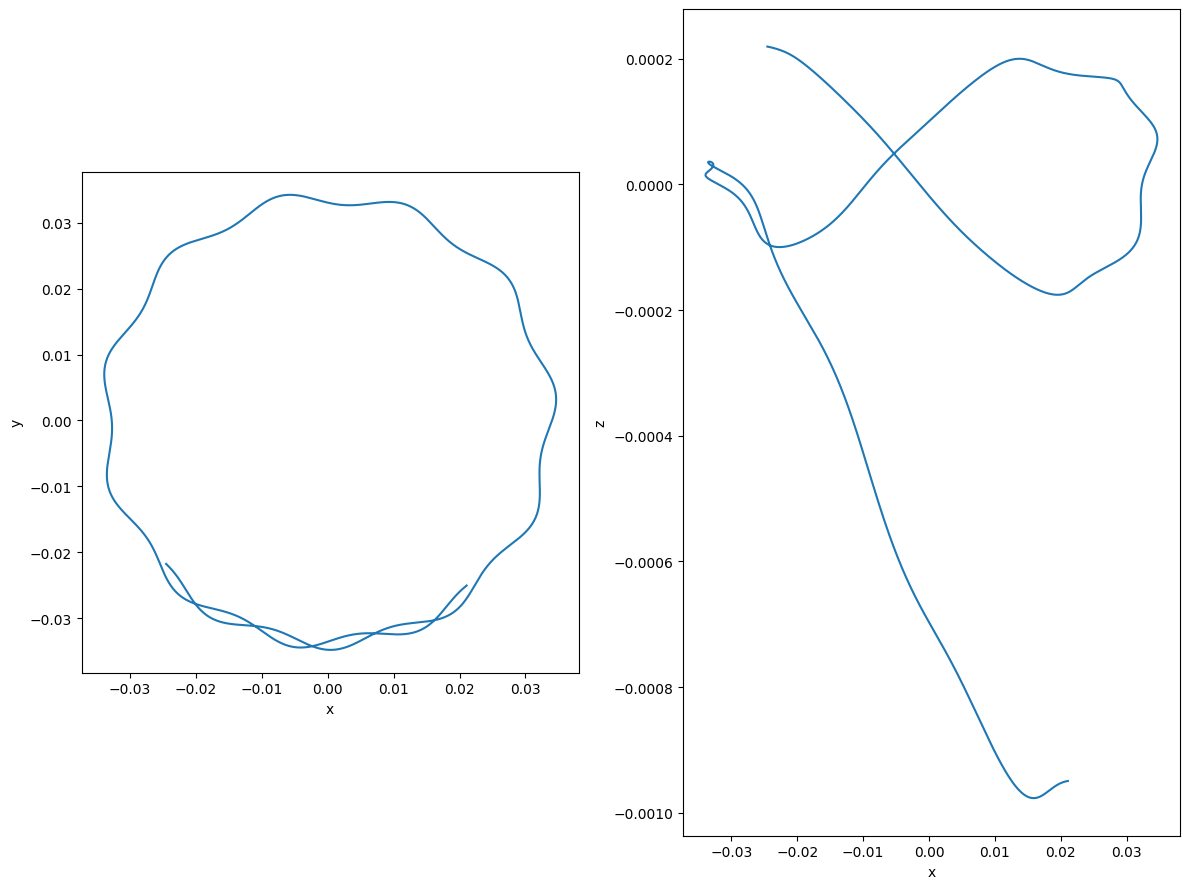

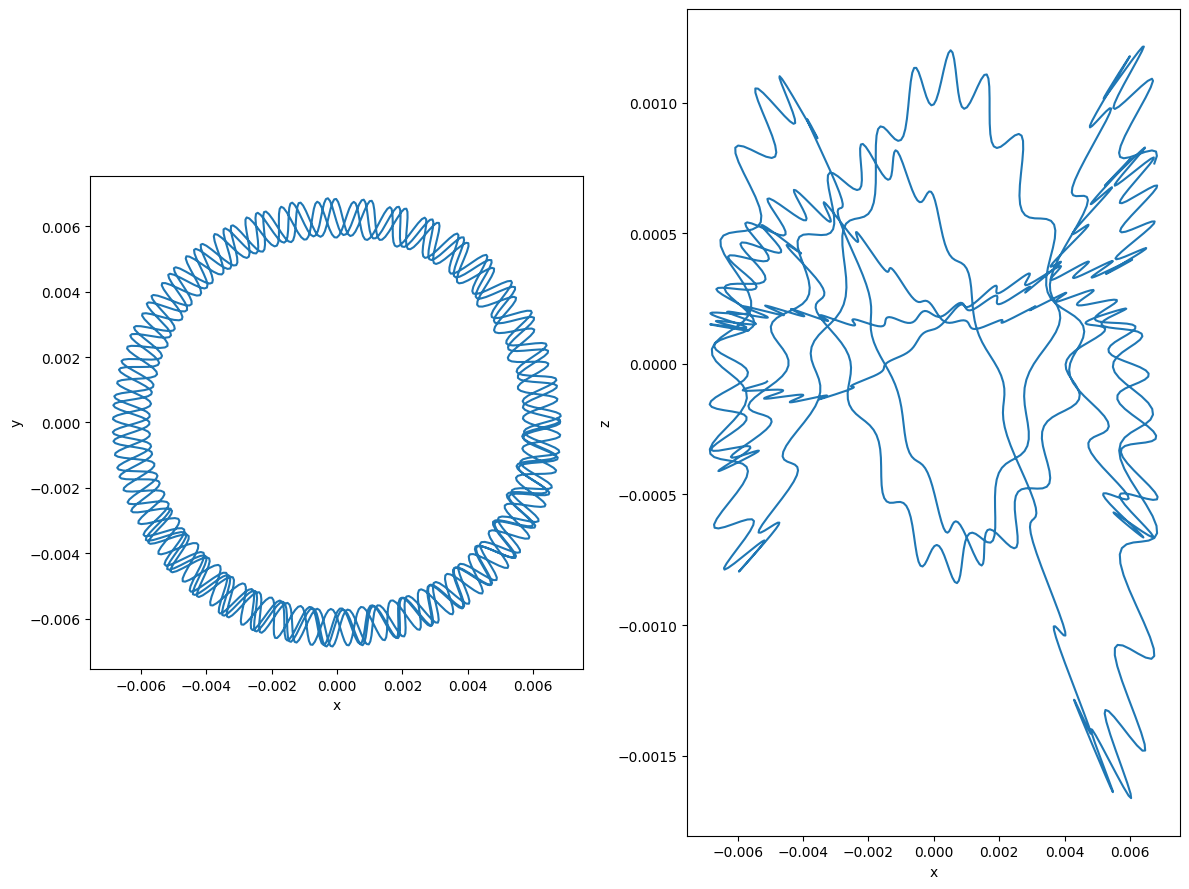

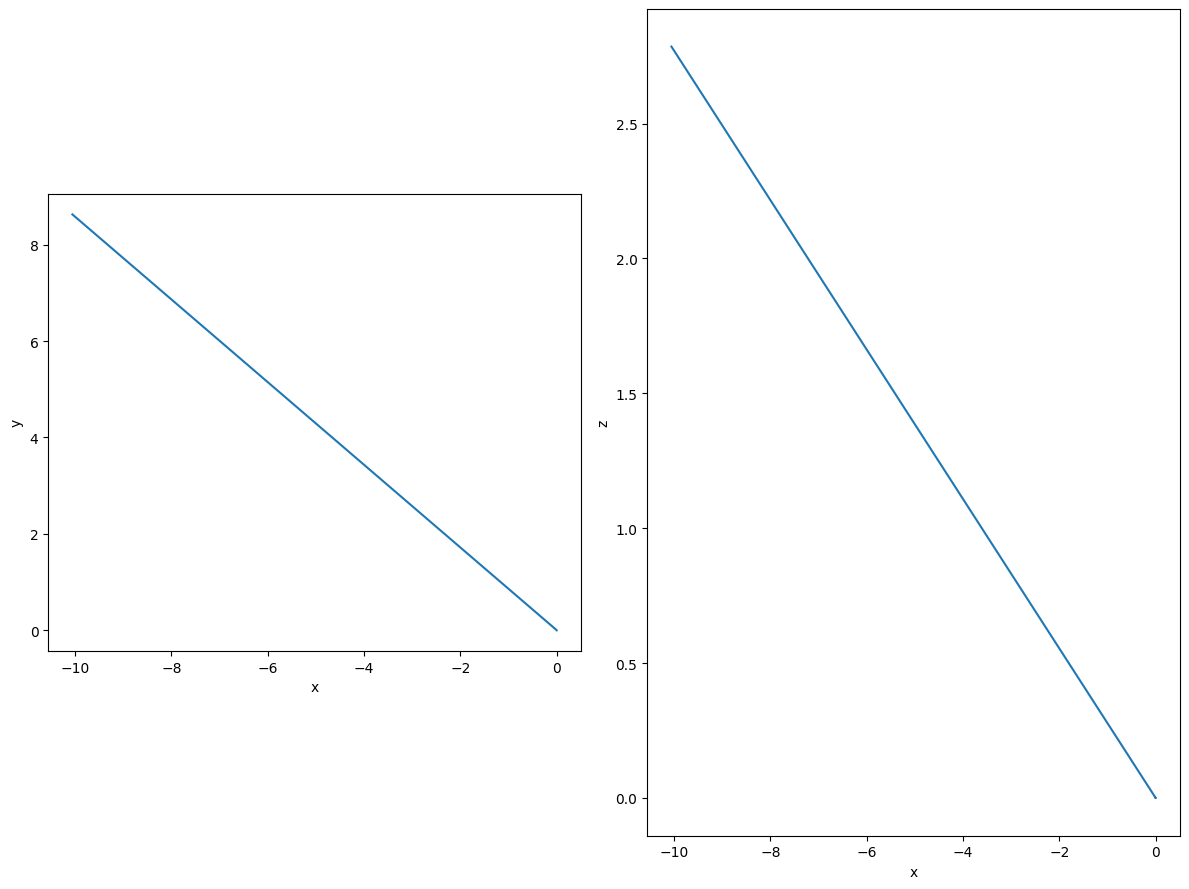

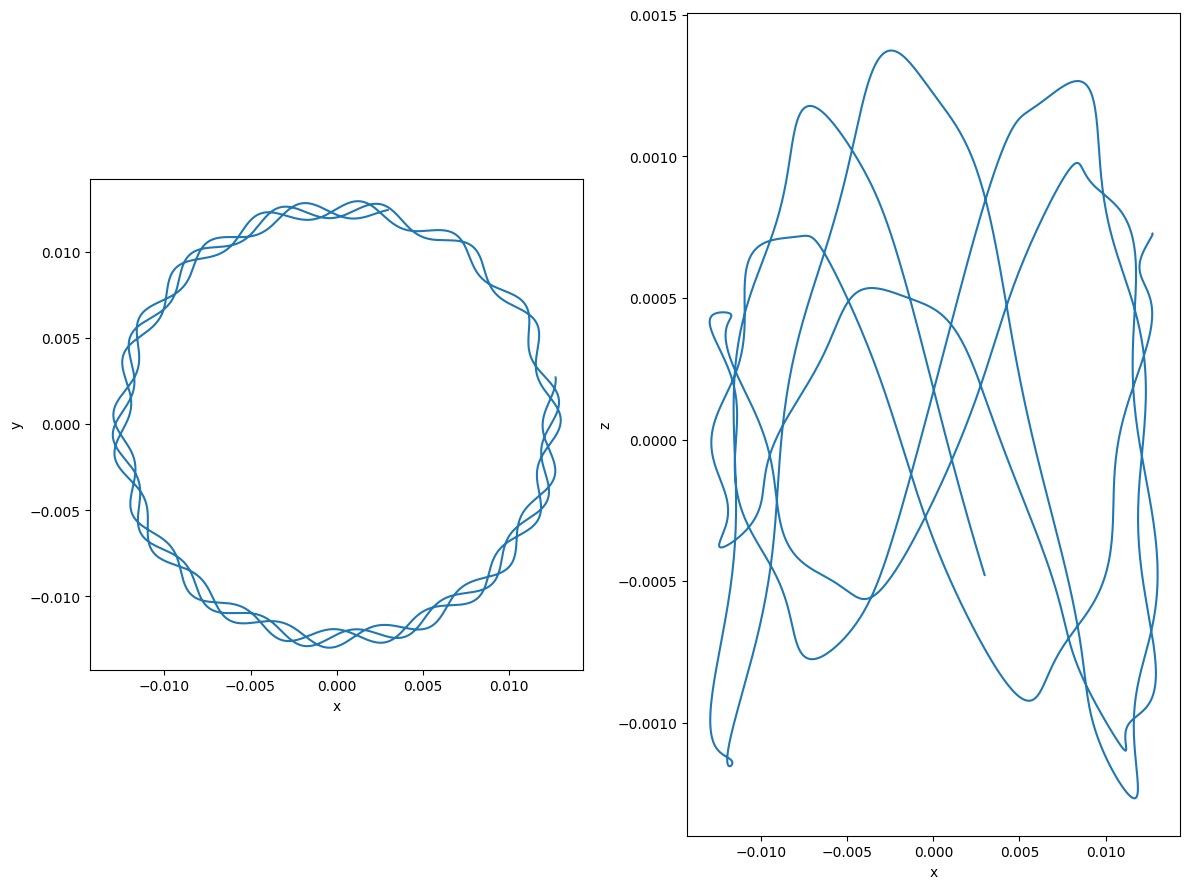

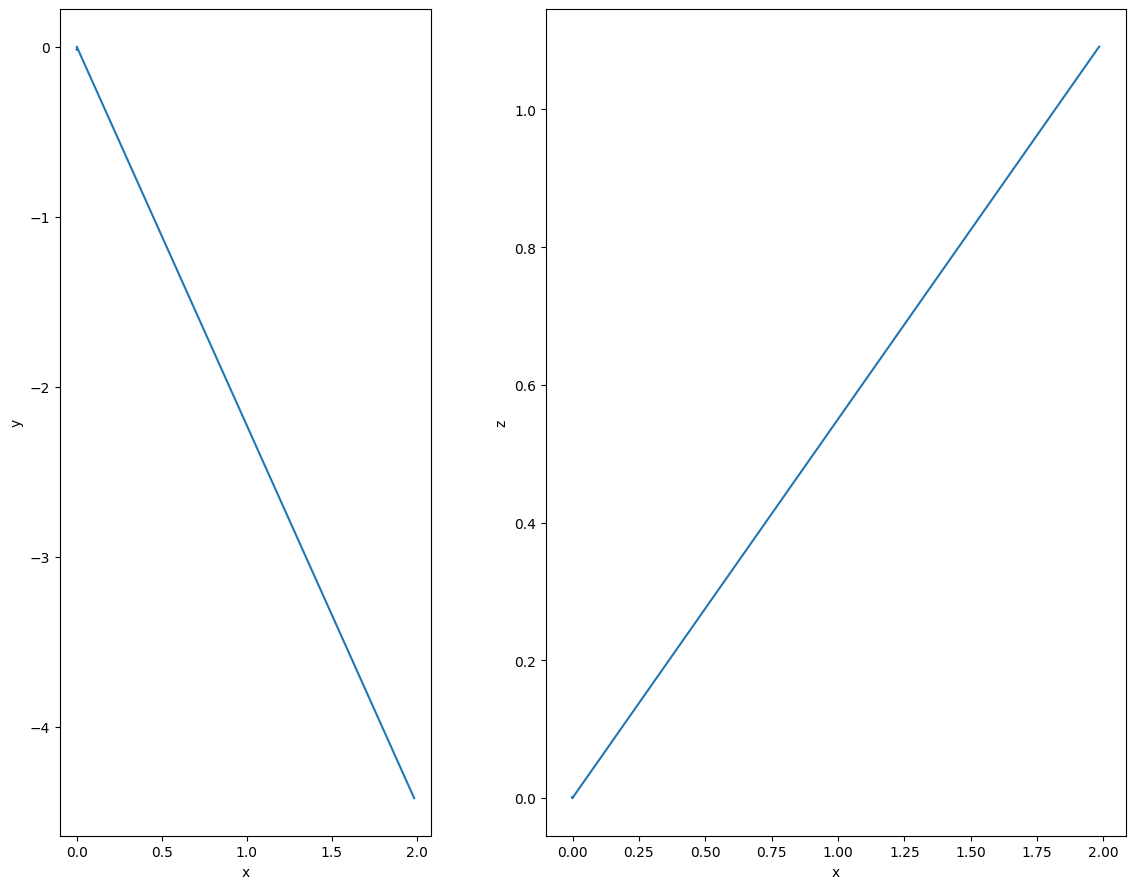

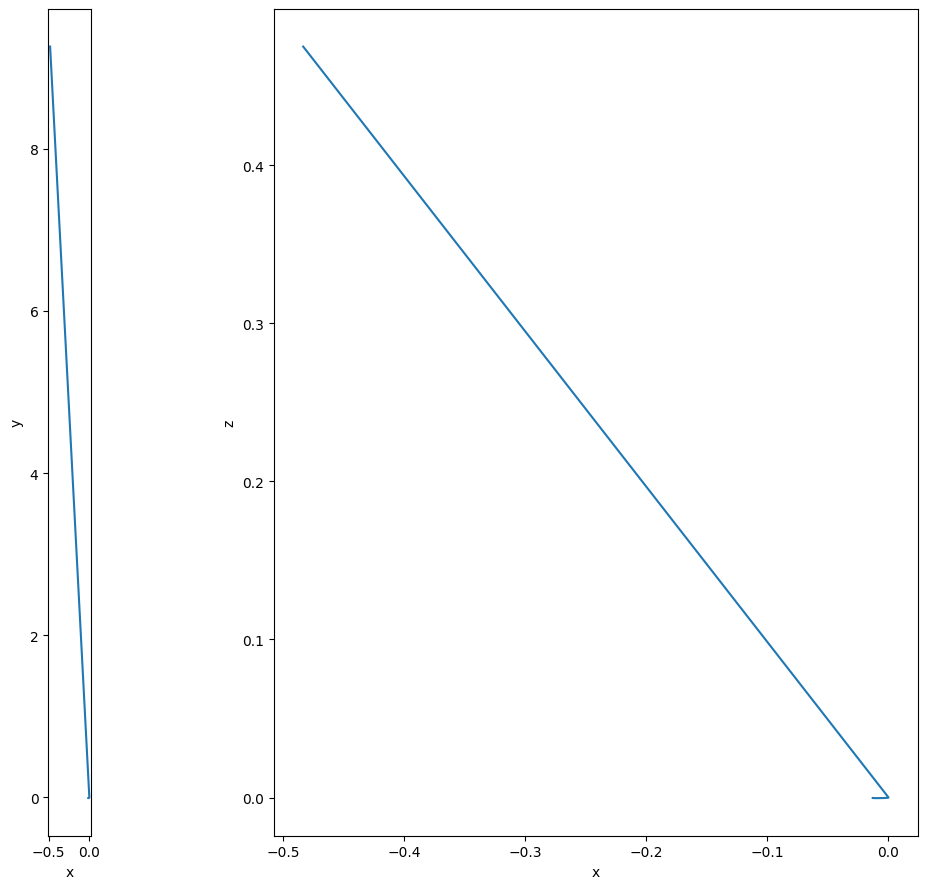

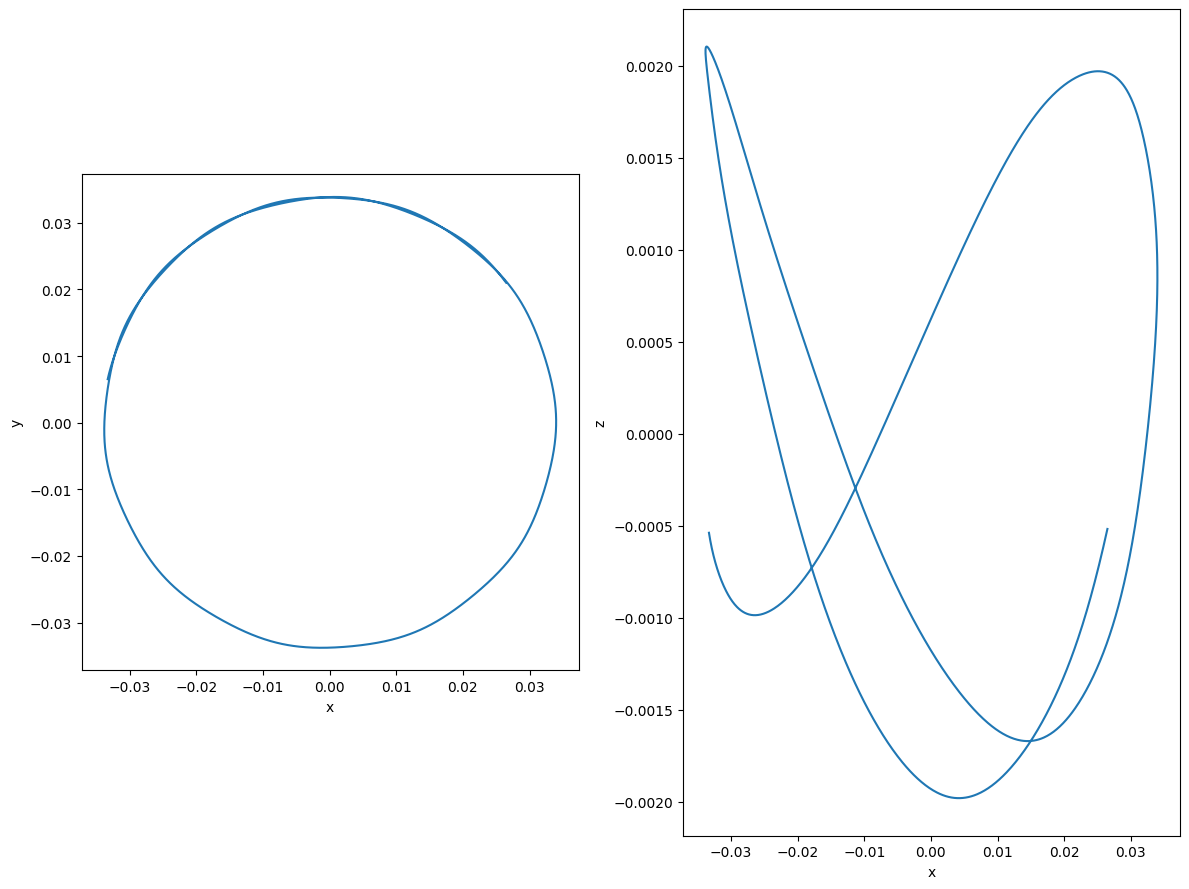

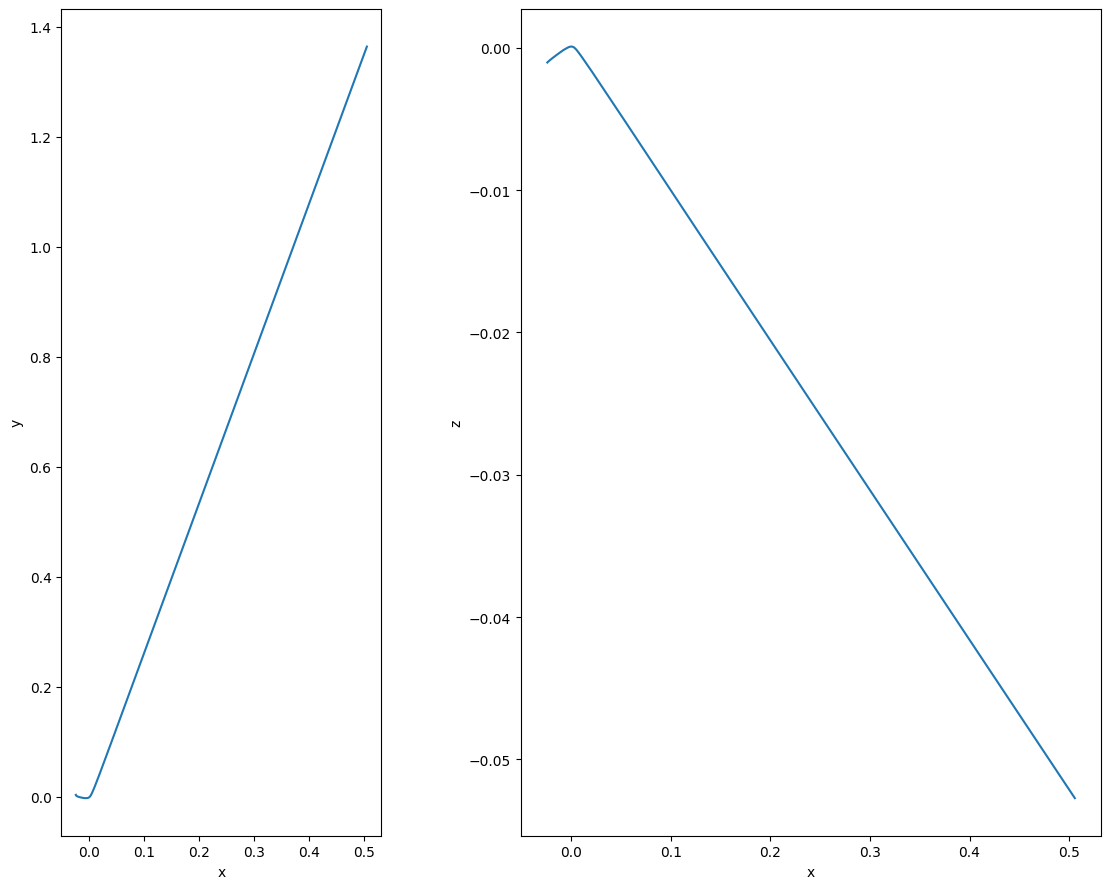

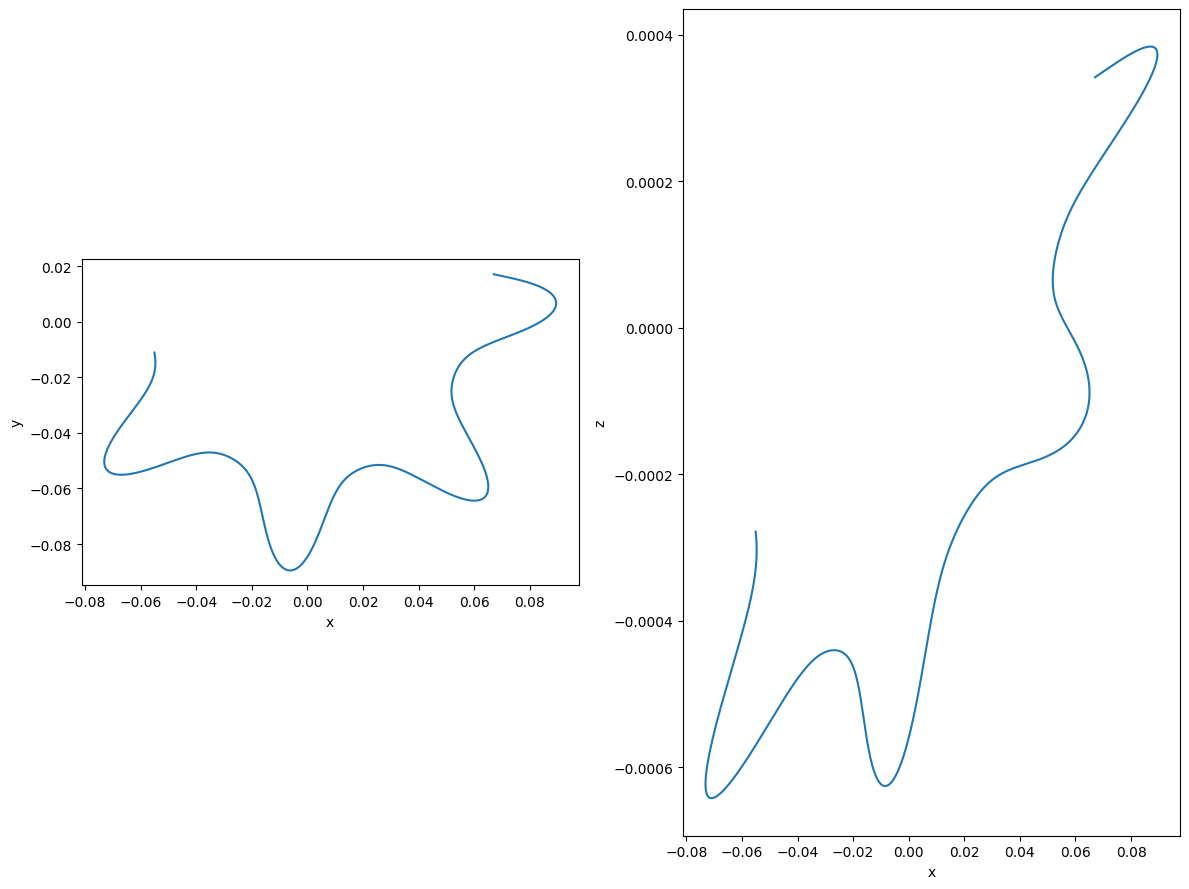

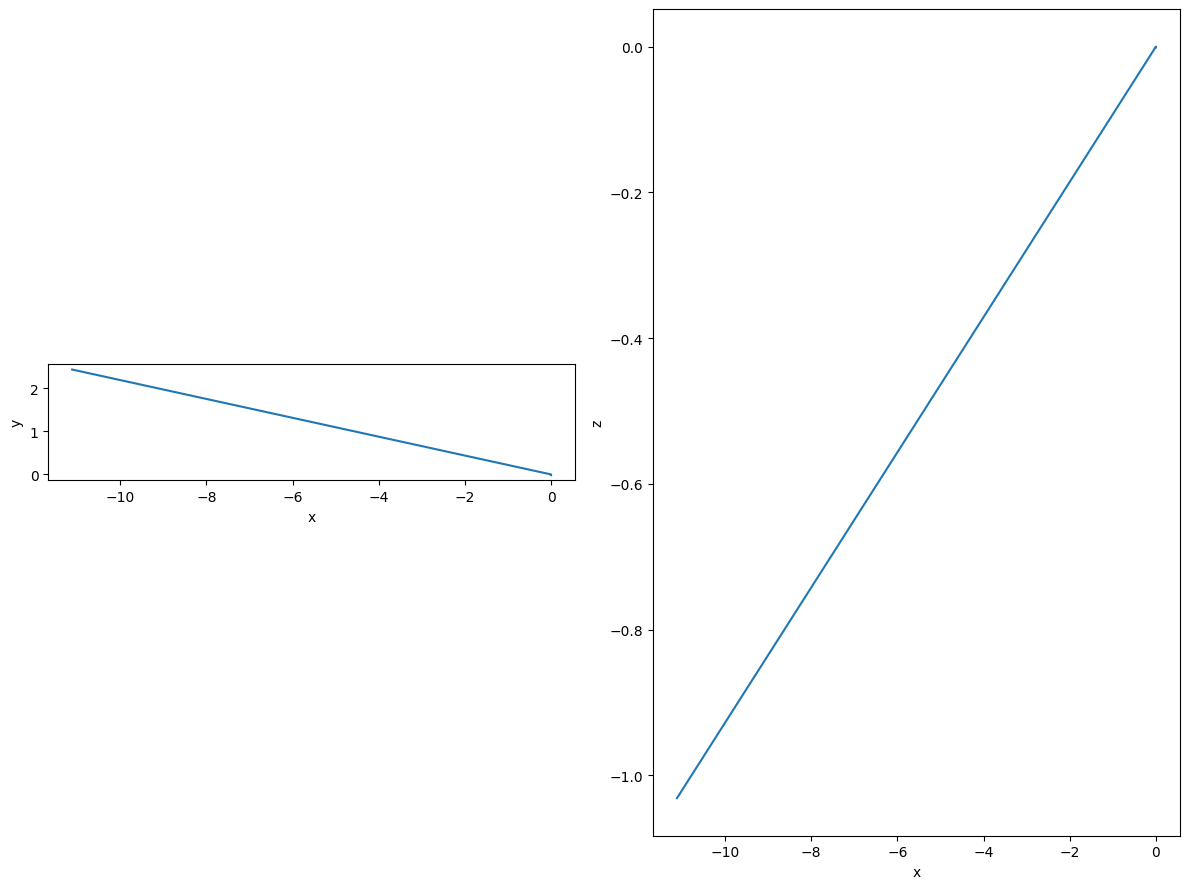

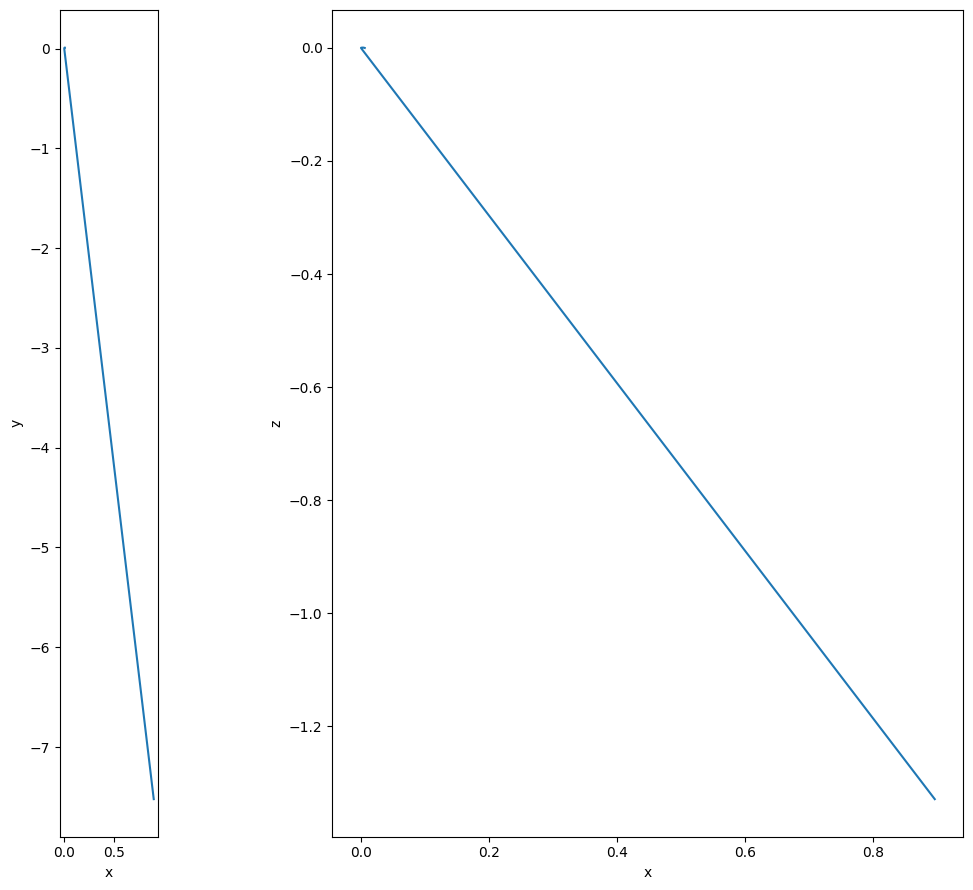

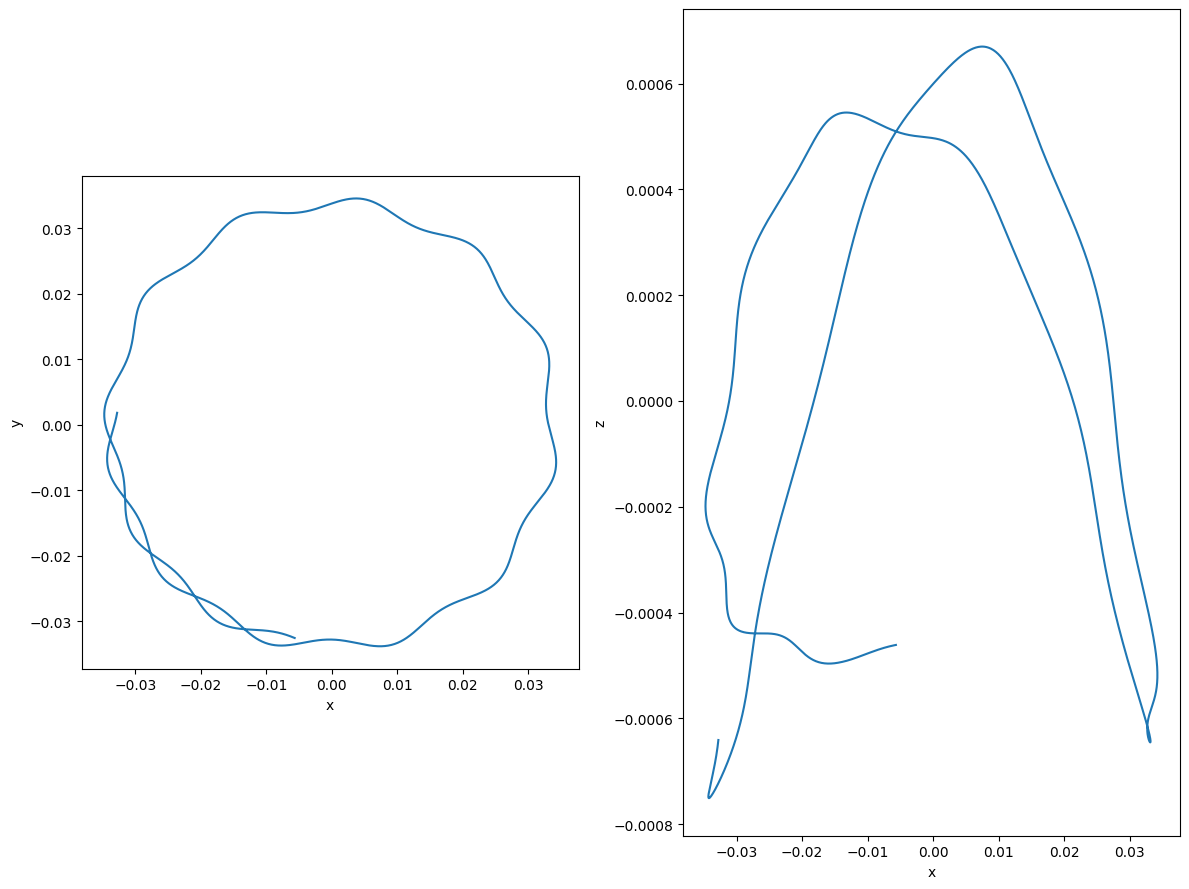

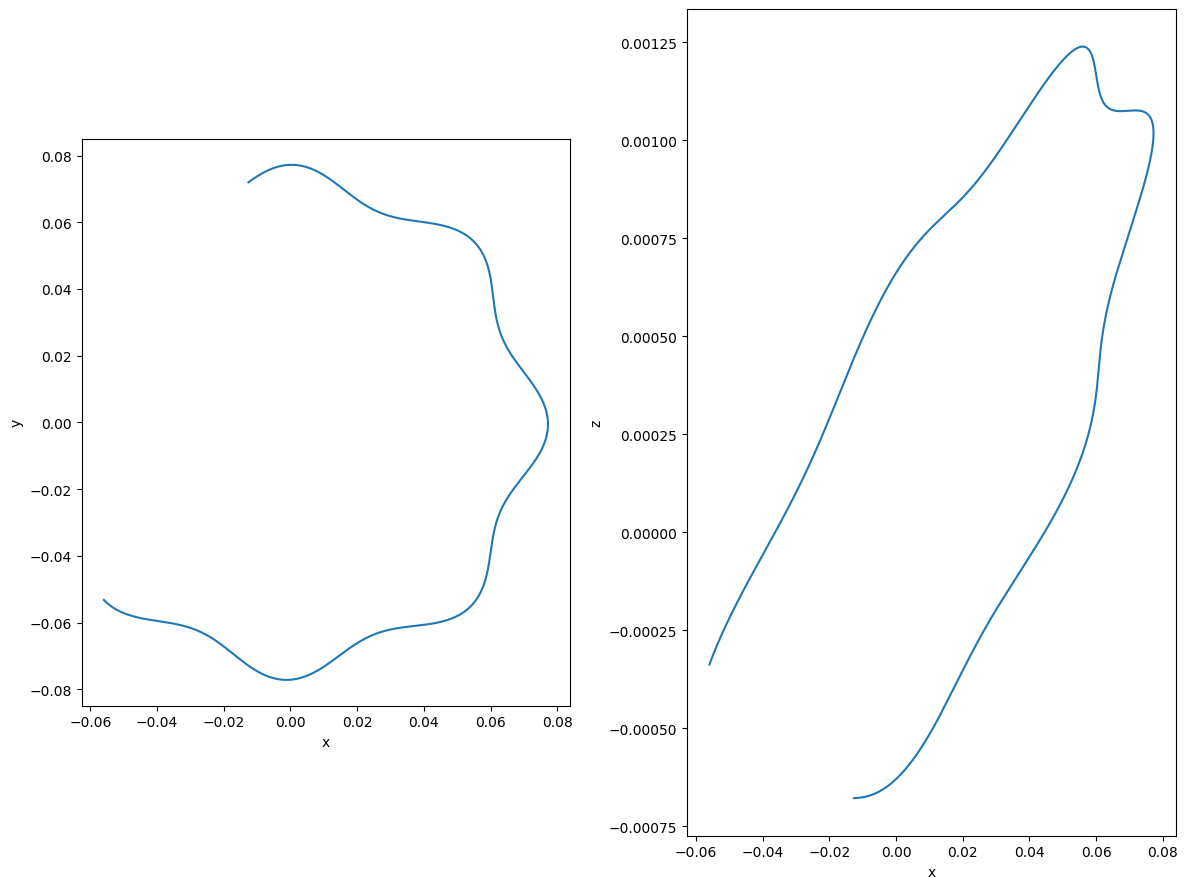

In [37]:
for n in range(orbits.shape[0]):
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(orbits[n,0,:], orbits[n,1,:])
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set(aspect=1)
    ax[1].plot(orbits[n,0,:], orbits[n,2,:])
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('z')
    plt.tight_layout()
    plt.show()